# Part 2: Feature Engineering, Modeling, & Evaluation

## Imports

In [1]:
import pandas                as pd
import numpy                 as np
import matplotlib.pyplot     as plt
import seaborn               as sns
import xgboost               as xgb
from math                    import sqrt
from sklearn.linear_model    import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.metrics         import r2_score, mean_squared_error, mean_absolute_error 
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing   import StandardScaler
from sklearn.ensemble        import RandomForestRegressor
from sklearn.pipeline        import Pipeline
from IPython.core.display    import display, HTML
from IPython.display         import display_html
sns.set(style = "white", palette = "husl")
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib inline

## Table Of Contents


1. [Reading In The Data](#Reading-In-The-Data)
    - [Overview](#Overview)


2. [Feature Engineering](#Feature-Engineering)
    - [Transforming Numeric Data](#Transforming-Numeric-Data)
    - [Creating Segmental Features](#Creating-Segmental-Features)
    

3. [Modeling](#Modeling)
    - [Functions](#Functions)
    - [Linear Regression](#Linear-Regression)
    - [Ridge](#Ridge)
    - [LASSO](#LASSO)
    - [ElasticNetCV](#ElasticNetCV)
    - [Random Forest Reression](#Random-Forest-Regression)
    - [XGBoosting](#XGBoost)
    - [Prediction Dataframes](#Prediction-Dataframes)
    

4. [Model Evaluation](#Model-Evaluation)
    - [Functions](#Evaluation-Functions)
    - [Plotting Predictions](#Plotting-Predictions)
    - [Plotting Residuals](#Plotting-Residuals)

## Reading In The Data

In [2]:
mri = pd.read_csv("../Data/mri_cleaned.csv")

### Overview

In [3]:
mri.head()

,sex,age,hypertension,hyperlipidemia,diabetes,lvedv,lvesv,lv_wall_thickness,lvef,aortic_stenosis,...,mis_ischemia,mi_ischemia,mil_ischemia,mal_ischemia,aa_ischemia,as_ischemia,ai_ischemia,al_ischemia,smoker_status_former,smoker_status_never
0,1,37,0,0,0,613,501,0,18,0,...,0,0,0,0,0,0,0,0,0,1
1,1,74,0,1,0,569,492,1,14,0,...,0,0,0,0,0,1,0,1,0,1
2,1,78,1,1,1,564,500,0,11,0,...,1,1,0,0,1,1,0,0,0,1
3,1,61,0,1,0,531,435,1,18,0,...,0,0,0,0,0,0,0,0,0,1
4,1,53,0,0,0,522,408,0,21,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# Checking the shape of the data

print(f"The shape of the dataset is: {mri.shape}")

The shape of the dataset is: (6417, 48)


In [5]:
# Summary of column data types

mri.dtypes.value_counts()

int64    48
dtype: int64

## Feature Engineering

### Transforming Numeric Data

There are only four numeric columns in the data set: `age`, `lvesv`, `lvedv`, `lvef`.  Of the four, only `lvef` does not have any kind of a normal distribution: `age` is close to normally distributed, while `lvesv` and `lvedv` are log-normally distributed.

We cannot do anything to `lvedv` because that is my target variable, but we can take the log of `lvesv` (in this case the natural log).  We also tried squaring `age` but that did not affect the distribution in the way we hoped it would.

In [6]:
# Take the natural log of `lvesv`.
# We chose to make it it's own column rather
# than overwrite the column.

mri["lvesv_log"] = mri["lvesv"].apply(lambda x: np.log(x))

In [7]:
print(f"The shape of the dataset is: {mri.shape}")

The shape of the dataset is: (6417, 49)


[Top](#Table-Of-Contents)

### Creating Segmental Features

Because the model attempts to predict the end diastolic volume, we want it to be as accurate as it can be.  As part of that, we will try to use different combinations of features in an attempt to achieve high accuracy.

The data have 34 columns that we wish to engineer: a column measuring scarification and a column measuring ischemia.  Because there are so many of them, we felt the need to experiment with how they are passed into the model.  We are unable to create multiplication interaction columns, because there are zeros.  Instead, we elected to create segmental columns by summing similar columns together: we will compare the model's performance with the originals and with the segmental columns.

We used this image to guide our create of segmental columns:

<img src = "../Images/cardiac-segmentation-for-cardiac-perfusion-defects.jpg" alt = "Cardiac Segmentation" height = 750 width = 750>

Case courtesy of Dr Hamid Chalian, <a href="https://radiopaedia.org/">Radiopaedia.org</a>. From the case <a href="https://radiopaedia.org/cases/47102">rID: 47102</a>

In [8]:
# Creating columns based off of the red, blue, green, and yellow
# We combined the apex and apical regions because there is only
# one region in the apex.

# New columns for scar tissue

mri["basal_he"]    = mri["ba_he"] + mri["bas_he"] + mri["bis_he"] \
                     + mri["bi_he"] + mri["bil_he"] + mri["bal_he"]
mri["mid_he"]      = mri["ma_he"] + mri["mas_he"] + mri["mis_he"] \
                     + mri["mi_he"] + mri["mil_he"] + mri["mal_he"]
mri["apical_he"]   = mri["aa_he"] + mri["as_he"] + mri["ai_he"] \
                     + mri["al_he"] + mri["apex_he"]

# New columns for ischemia

mri["basal_ischemia"]  = mri["ba_ischemia"] + mri["bas_ischemia"] + mri["bis_ischemia"] \
                         + mri["bi_ischemia"] + mri["bil_ischemia"] + mri["bal_ischemia"]
mri["mid_ischemia"]    = mri["ma_ischemia"] + mri["mas_ischemia"] + mri["mis_ischemia"] \
                         + mri["mi_ischemia"] + mri["mil_ischemia"] + mri["mal_ischemia"]
mri["apical_ischemia"] = mri["aa_ischemia"] + mri["as_ischemia"] + mri["ai_ischemia"] \
                         + mri["al_ischemia"]

print(f"The shape of the dataset is: {mri.shape}")

The shape of the dataset is: (6417, 55)


We intended to create new columns based off the secondary axis (anteroseptal, inferoseptal, etc.) but because of how the apical region is divided we would have counted the apical regions more than once.

[Top](#Table-Of-Contents)

One of our goals was to see what would happen if we used the engineered features to reduce the overall number of reatures being passed into the model.  To accomplish that, we created two dataframes: one with the original set of features (48 including the target) and a second one with the engineered features (21 including the target).


From this point on, `_org` will be used to refer to the original set of features and `_eng` will be use to refer to the engineered features.  The default will be `_org`, so after train-splitting the originial will just be `X_train` or `X_train_ss`.

In [9]:
# Defining the original dataframe

mri_org = mri.drop(labels = ["lvesv_log", "basal_he", "mid_he",
                             "apical_he", "basal_ischemia",
                             "mid_ischemia", "apical_ischemia"],
                   axis = 1)

# Defining the dataframe with only new features

mri_eng = mri.drop(labels = ['lvesv', 'ba_he', 'bas_he', 'bis_he','bi_he', 
                             'bil_he', 'bal_he', 'ma_he', 'mas_he', 'mis_he', 
                             'mi_he', 'mil_he','mal_he', 'aa_he', 'as_he', 
                             'ai_he', 'al_he', 'apex_he', 'ba_ischemia',
                             'bas_ischemia', 'bis_ischemia', 'bi_ischemia', 
                             'bil_ischemia','bal_ischemia', 'ma_ischemia', 
                             'mas_ischemia', 'mis_ischemia','mi_ischemia', 
                             'mil_ischemia', 'mal_ischemia', 'aa_ischemia', 
                             'as_ischemia', 'ai_ischemia', 'al_ischemia'],
                   axis = 1)

# Checking to make sure the two have different numbers of columns

print(f"The shape of the dataframe with original features is  : {mri_org.shape}")
print(f"The shape of the dataframe with engineered features is: {mri_eng.shape}")

The shape of the dataframe with original features is  : (6417, 48)
The shape of the dataframe with engineered features is: (6417, 21)


[Top](#Table-Of-Contents)

## Modeling

Before we can start modeling, we have to perform a train-test split.  A train-test split allows us to train our data on one subset of the dataframe and train on another subset.

Since I have two versions of the dataframe, I will have to train-test split on both.

In [10]:
# Setting up my X and y variables for the original

X = mri_org.drop("lvedv", axis = 1)
y = mri_org["lvedv"]

# Setting up my X and y variables for the new

X_eng = mri_eng.drop("lvedv", axis = 1)
y_eng = mri_eng["lvedv"]

In [11]:
# Train-test splitting mri_og

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y,
                                                    random_state = 42,
                                                    test_size    = 0.25) 

# Train-test splitting mri_new

X_train_eng, X_test_eng, y_train_eng, y_test_eng = train_test_split(X_eng, 
                                                                    y_eng,
                                                                    random_state = 42,
                                                                    test_size    = 0.25) 

Each model going forward will be fit and evaluated on both sets of train-test splits.

Since I will be running models that need to have the data scaled, I will run both sets of X variables through `StandardScaler`.

In [12]:
# Instantiating the standard scaler

ss = StandardScaler()

In [13]:
# Transforming the set with original 
# features.

# Fit-transforming the X_train features

X_train_ss = ss.fit_transform(X_train)

# Transforming my X_test variables

X_test_ss  = ss.transform(X_test)

In [14]:
# Transforming the sub-set with the
# features I engineered

# Fit-transforming the engineered X_train

X_train_eng_ss = ss.fit_transform(X_train_eng)

# Transforming the engineered X_test features

X_test_eng_ss  = ss.transform(X_test_eng)

### Functions

In [15]:
# Formula to generate an adjusted r^2 score for
# my model evaluation function in the next cell

# This formula was take from the linear regression lab

def r2_adj(X, y_true, y_predicted):
    r2          = r2_score(y_true, y_predicted)
    numerator   = (1 - r2) * (len(y) - 1)
    denominator = (len(y) - len(X.columns)) - 1
    quotient    = numerator / denominator
    r2_adj      = 1 - quotient
    return r2_adj

The `model_evaluation` function has four metrics:

* r<sup>2</sup> to measure variance in `y` caused by the `X` variables;


* adjusted r<sup>2</sup> to measure the same, but weighted for the number of features;


* root mean squared error (RMSE) to measure the difference between my predicted values and the actual values;


* mean absolute error (MAE) to measure the absolute mean error (this method is less sensitive to outliers).

In [16]:
def model_evaluation(X, y_true, y_predicted):
    rmse = sqrt(mean_squared_error(y_true, y_predicted))
    mae  = mean_absolute_error(y_true, y_predicted)
    r2   = r2_score(y_true, y_predicted)
    print(f"The root mean squared error is : {rmse}")
    print(f"The mean absolute error is     : {mae}")
    print(f"The r2 score is                : {r2}")
    print(f"The adjusted r2 score is       : {r2_adj(X, y_true, y_predicted)}")

In [17]:
# This is the same as the cell above, but lacking the adjusted r^2 score
# because after standard scaling the `X` variables the columns are lost.

def model_evaluation_nor2adj(y_true, y_predicted):
    rmse = sqrt(mean_squared_error(y_true, y_predicted))
    mae  = mean_absolute_error(y_true, y_predicted)
    r2   = r2_score(y_true, y_predicted)
    print(f"The root mean squared error is : {rmse}")
    print(f"The mean absolute error is     : {mae}")
    print(f"The r2 score is                : {r2}")

The following code is from user ntg on StackOverflow.  [Here](https://stackoverflow.com/a/44923103) is the source.

In [18]:
# This allows me to display the dataframes of the linear regression
# coefficients side-by-side to save space.

def display_side_by_side(*args):
    html_str = ''
    for df in args:
        html_str += df.to_html()
    display_html(html_str.replace('table', 'table style="display:inline"'), raw = True)

[Top](#Table-Of-Contents)

### Linear Regression

When thinking about our approach to modeling, we decided to start with the simplest model we could think of which was the linear regression.

#### Original Set

The original set is the dataframe with its original 48 columns.

In [19]:
# Instantiating the linear regression

lr = LinearRegression()

In [20]:
# Fitting the linear regression to the original
# (non-engineered) subset

lr.fit(X_train, y_train);

In [21]:
# Generating predictions from the training set

train_preds = lr.predict(X_train)

# Generating my test predictions

lr_preds = lr.predict(X_test)

In [22]:
model_evaluation(X_train, y_train, train_preds)

The root mean squared error is : 16.416572717672008
The mean absolute error is     : 12.076837694615273
The r2 score is                : 0.9258469775866639
The adjusted r2 score is       : 0.9252997657710842


In [23]:
model_evaluation(X_test, y_test, lr_preds)

The root mean squared error is : 17.474492744600283
The mean absolute error is     : 12.896847595997924
The r2 score is                : 0.9237493878185266
The adjusted r2 score is       : 0.9231866968509447


Based off of how similar the scores are, it is clear that the model is performing very well.

The model is technically overfit, but it is so minor we decided to ignore the overfit.

In [24]:
# Creating a dataframe makes looking the coefficients easier

lin_reg_org = pd.DataFrame(data    = lr.coef_,
                           index   = X_test.columns,
                           columns = ["Lin_Reg_Org"])

# Sorting for the head and tail five coefficients

head = lin_reg_org.sort_values(by = "Lin_Reg_Org", ascending = False).head()
tail = lin_reg_org.sort_values(by = "Lin_Reg_Org", ascending = False).tail()

display_side_by_side(head,tail)

,Lin_Reg_Org
sex,10.864849
smoker_status_former,3.329839
smoker_status_never,3.101885
mil_ischemia,1.894495
lvef,1.755295
,Lin_Reg_Org
mas_ischemia,-1.323619
hyperlipidemia,-1.667128
al_ischemia,-1.739566
ba_ischemia,-2.837152


Displaying the heads and tails displays showed us the strongest and weakest coefficients as determined during the modeling process.

We found it interesting that sex and smoker status were so strong, but hyperlipidemia was so weak in comparison: hicgh cholesterol is a significant factor for cardiac disease.

#### Engineered Subset

The engineered subset is the dataframe but with the features we engineered instead of the original 34 segmental features.

In [25]:
# Instantiating the linear model

lr_2 = LinearRegression()

In [26]:
# Fitting the linear regression to the subset
# with the features I engineered

lr_2.fit(X_train_eng, y_train_eng);

In [27]:
# Generating predictions for the training set

train_preds = lr_2.predict(X_train_eng)

# Generating my predictions for the testing set

lr_2_preds  = lr_2.predict(X_test_eng)

In [28]:
model_evaluation(X_train_eng, y_train_eng, train_preds)

The root mean squared error is : 23.306991935523463
The mean absolute error is     : 14.592137130598315
The r2 score is                : 0.8505360968014757
The adjusted r2 score is       : 0.8500687299997292


In [29]:
model_evaluation(X_test_eng, y_test_eng, lr_2_preds)

The root mean squared error is : 23.111112718046606
The mean absolute error is     : 15.234989524246423
The r2 score is                : 0.8666245521501372
The adjusted r2 score is       : 0.8662074932137712


The scores for the engineered subset are worse than for the original dataset, but they are even more consistant.

This was firm evidence for us that a linear type model likely is the best way to model this data.

In [30]:
# It is easier to view the coefficients in a df

lin_reg_eng = pd.DataFrame(data  = lr_2.coef_,
                           index = X_test_eng.columns,
                           columns = ["Lin_Reg_Eng"])

In [31]:
head = lin_reg_eng.sort_values(by = "Lin_Reg_Eng", ascending = False).head()
tail = lin_reg_eng.sort_values(by = "Lin_Reg_Eng", ascending = False).tail()

display_side_by_side(head,tail)

,Lin_Reg_Eng
lvesv_log,129.015341
mitral_reg,5.307152
lvef,2.253598
hypertension,2.104900
lv_wall_thickness,2.094055
,Lin_Reg_Eng
basal_he,-0.205841
smoker_status_never,-1.111246
diabetes,-1.244056
mid_ischemia,-1.261124


[Top](#Table-Of-Contents)

### Ridge

Ridge regression works by imposing a penalty on the coefficients: it uses the $\ell$<sub>2</sub> regularization which shrinks thems towards 0 and effectively removes features without actually doing so and reduces the overall complexity.


Because the features can be so strongly affected by the regularization it is important to have them all be on the same scale; this was done aboe with `StandardScaler`.

#### Original Set

In [32]:
# Instantiating the ridge model

ridge = RidgeCV()

In [33]:
# Fitting the ridge model to the training data

ridge.fit(X_train_ss, y_train);

In [34]:
# Generating predictions for the training set

train_preds = ridge.predict(X_train_ss)

# Generating Predictions for the testing set

ridge_preds = ridge.predict(X_test_ss)

Becuase the RidgeCV and following models use scaled data, they lose the feature columns and instead use arrays of data.  For this reason, an adjusted r<sup>2</sup> cannot be used.

In [35]:
model_evaluation_nor2adj(y_train, train_preds)

The root mean squared error is : 16.42040617933562
The mean absolute error is     : 12.115056107447613
The r2 score is                : 0.9258123423478851


In [36]:
model_evaluation_nor2adj(y_test, ridge_preds)

The root mean squared error is : 17.4627798093733
The mean absolute error is     : 12.93357119857244
The r2 score is                : 0.9238515732348865


This Ridge model's performance is very similar to the linear model's performance which was surprising to us because we had expected the regularization to improve its performance.

#### Engineered Subset

In [37]:
# Instantiating the ridge model

ridge_2 = RidgeCV()

In [38]:
# Fitting the ridge model to the data
# with engineered features.

ridge_2.fit(X_train_eng_ss, y_train_eng);

In [39]:
# Generating predictions for the trianing data

train_preds = ridge_2.predict(X_train_eng_ss)

# Generating Predictions

ridge_2_preds = ridge_2.predict(X_test_eng_ss)

In [40]:
model_evaluation_nor2adj(y_train_eng, train_preds)

The root mean squared error is : 23.307036851719992
The mean absolute error is     : 14.59437914664354
The r2 score is                : 0.8505355207205694


In [41]:
model_evaluation_nor2adj(y_test_eng, ridge_2_preds)

The root mean squared error is : 23.11285690232428
The mean absolute error is     : 15.236579363787632
The r2 score is                : 0.8666044198319497


[Top](#Table-Of-Contents)

### LASSO

LASSO (Least Absolute Shrinkage and Selection Operator) is conceptually similar to Ridge in that it penalizes coefficients, but it uses $\ell$<sub>2</sub> regularization which actually reduces the coefficients of unimportant features to exactly 0.

LASSO also needs to have the features on the same scale.

#### Original Set

In [42]:
# Instantiating the LASSO model

lasso = LassoCV()

In [43]:
# Fitting the lasso to my training data
# without engineered features

lasso.fit(X_train_ss, y_train)

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [44]:
# Generating predictions for the training data

train_preds = lasso.predict(X_train_ss)

# Generating predictions for the testing data

lasso_preds = lasso.predict(X_test_ss)

In [45]:
model_evaluation_nor2adj(y_train, train_preds)

The root mean squared error is : 16.464926023979082
The mean absolute error is     : 12.132529959476345
The r2 score is                : 0.925409514263332


In [46]:
model_evaluation_nor2adj(y_test, lasso_preds)

The root mean squared error is : 17.452841587008194
The mean absolute error is     : 12.939964432287836
The r2 score is                : 0.9239382220572515


#### Engineered Subset

In [47]:
# Instantiating the lasso model

lasso_2 = LassoCV()

In [48]:
# Fitting the lasso to my training data
# with engineered features

lasso_2.fit(X_train_eng_ss, y_train_eng)

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


LassoCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [49]:
# Generating predictions for the training data

train_preds = lasso_2.predict(X_train_eng_ss)

# Generating predictions for the testing data

lasso_2_preds = lasso_2.predict(X_test_eng_ss)

In [50]:
model_evaluation_nor2adj(y_train, train_preds)

The root mean squared error is : 23.332976290429542
The mean absolute error is     : 14.649484238864776
The r2 score is                : 0.8502026442437456


In [51]:
model_evaluation_nor2adj(y_test_eng, lasso_2_preds)

The root mean squared error is : 23.166184744532803
The mean absolute error is     : 15.294185552657328
The r2 score is                : 0.8659881476740601


[Top](#Table-Of-Contents)

### ElasticNetCV

Elastic net models are similar to both Ridge _and_ LASSO models: they are a compromise between the $\ell$<sub>1</sub> and$\ell$<sub>2</sub> regularizations.  In practice the model drives down non-significant features but does not remove them entirely.

-----

Like the Ridge and LASSO models, an ElasticNet needs to have the data be on the same scale.

#### Original Set

In [52]:
# Instantiating the model

enet = ElasticNetCV()

In [53]:
# Fitting the model to the 
# original data set

enet.fit(X_train_ss, y_train)

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


ElasticNetCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
             l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [54]:
# Generating training predictions

train_preds = enet.predict(X_train_ss)

# Generating testing predictions

enet_preds = enet.predict(X_test_ss)

In [55]:
model_evaluation_nor2adj(y_train, train_preds)

The root mean squared error is : 18.00526616920079
The mean absolute error is     : 13.804343899364056
The r2 score is                : 0.9108003891975689


In [56]:
model_evaluation_nor2adj(y_test, enet_preds)

The root mean squared error is : 18.71825193430591
The mean absolute error is     : 14.381573761551651
The r2 score is                : 0.912508722920664


#### Engineered Subset

In [57]:
# Instantiatig the model

enet_2 = ElasticNetCV()

In [58]:
# Fitting the model to the data
# with engineered features

enet_2.fit(X_train_eng_ss, y_train_eng)

C:\Users\andre\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


ElasticNetCV(alphas=None, copy_X=True, cv='warn', eps=0.001, fit_intercept=True,
             l1_ratio=0.5, max_iter=1000, n_alphas=100, n_jobs=None,
             normalize=False, positive=False, precompute='auto',
             random_state=None, selection='cyclic', tol=0.0001, verbose=0)

In [59]:
# Generating training predictions

train_preds = enet_2.predict(X_train_eng_ss)

# Generating testing predictions

enet_2_preds = enet_2.predict(X_test_eng_ss)

In [60]:
model_evaluation_nor2adj(y_train_eng, train_preds)

The root mean squared error is : 24.750636813677065
The mean absolute error is     : 16.218553615656663
The r2 score is                : 0.8314469472575524


In [61]:
model_evaluation_nor2adj(y_test_eng, enet_2_preds)

The root mean squared error is : 24.881057382163224
The mean absolute error is     : 16.691842447714198
The r2 score is                : 0.845413400147587


[Top](#Table-Of-Contents)

### Random Forest Regression

A random forest regressor works by bagging (bootstrap aggregation) random samples of the original dataframe and uses a metric (in our case MSE) to determine the quality of a split.  When it comes to predicting, it generates the mean of each node.

We chose to use a pipeline to make it easier for us to find optimal hyperparameter values; hyperparameters are parameters defined by the individual running the code.

#### Original Set

In [62]:
# Instantiating the pipeline

rfr_pipe = Pipeline([("rfr", RandomForestRegressor(random_state = 42))])

In [63]:
# Setting the values for the gridsearch
# These are the optimized values

params = {"rfr__n_estimators"     : [35],
          "rfr__max_depth"        : [None],
          "rfr__min_samples_split": [10],
          "rfr__min_samples_leaf" : [2,],
          "rfr__n_jobs"           : [6]}

# Instantiating the gridsearch

rfr_gs = GridSearchCV(rfr_pipe, 
                      param_grid = params,
                      cv         = 5)

# Fitting the gridsearch to the training data

rfr_gs.fit(X_train, y_train);

# Getting the best parameters

rfr_gs.best_params_

{'rfr__max_depth': None,
 'rfr__min_samples_leaf': 2,
 'rfr__min_samples_split': 10,
 'rfr__n_estimators': 35,
 'rfr__n_jobs': 6}

In [64]:
# Generating training predictions

train_preds = rfr_gs.predict(X_train)

# Generating testing predictions

rfr_preds = rfr_gs.predict(X_test)

In [65]:
model_evaluation(X_train, y_train, train_preds)

The root mean squared error is : 4.426234051218963
The mean absolute error is     : 1.9267013511015492
The r2 score is                : 0.994609455724008
The adjusted r2 score is       : 0.9945696762325695


In [66]:
model_evaluation(X_test, y_test, rfr_preds)

The root mean squared error is : 5.750231631733555
The mean absolute error is     : 2.907834110888434
The r2 score is                : 0.9917433313156421
The adjusted r2 score is       : 0.9916824012751074


#### Engineered Subset

In [67]:
# Setting the values for the gridsearch
# These are the optimized values

params = {"rfr__n_estimators"     : [35],
          "rfr__max_depth"        : [None],
          "rfr__min_samples_split": [2],
          "rfr__min_samples_leaf" : [2],
          "rfr__n_jobs"           : [6]}

# Instantiating the gridsearch

rfr_2_gs = GridSearchCV(rfr_pipe, 
                        param_grid = params,
                        cv         = 5)

# Fitting the gridsearch to the training data

rfr_2_gs.fit(X_train_eng, y_train_eng);

# Getting the best parameters

rfr_2_gs.best_params_

{'rfr__max_depth': None,
 'rfr__min_samples_leaf': 2,
 'rfr__min_samples_split': 2,
 'rfr__n_estimators': 35,
 'rfr__n_jobs': 6}

In [68]:
# Generating training predictions

train_preds = rfr_2_gs.predict(X_train_eng)

# Generating testing predictions

rfr_2_preds = rfr_2_gs.predict(X_test_eng)

In [69]:
model_evaluation(X_train_eng, y_train_eng, train_preds)

The root mean squared error is : 3.5809933246840426
The mean absolute error is     : 1.4378725598907294
The r2 score is                : 0.9964716562433406
The adjusted r2 score is       : 0.9964606232734948


In [70]:
model_evaluation(X_test_eng, y_test_eng, rfr_2_preds)

The root mean squared error is : 5.429875875269961
The mean absolute error is     : 2.770788142777462
The r2 score is                : 0.9926376919827254
The adjusted r2 score is       : 0.9926146703816708


[Top](#Table-Of-Contents)

### XGBoosting

#### Original Set

In [71]:
# Instantiating the xgboost regressor

xgbr = xgb.XGBRegressor()

In [72]:
# Fitting to my training data

xgbr.fit(X_train, y_train);

[16:44:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\andre\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [73]:
# Generating training predictions

train_preds = xgbr.predict(X_train)

# Generating testing predictions

xgbr_preds = xgbr.predict(X_test)

In [74]:
model_evaluation(X_train, y_train, train_preds)

The root mean squared error is : 5.8451301412383945
The mean absolute error is     : 3.4419462508394236
The r2 score is                : 0.9905994722022834
The adjusted r2 score is       : 0.9905301010597976


In [75]:
model_evaluation(X_test, y_test, xgbr_preds)

The root mean squared error is : 6.8018837951461775
The mean absolute error is     : 4.012041278494482
The r2 score is                : 0.9884470579360995
The adjusted r2 score is       : 0.9883618030645336


In [76]:
# Creating a coefficients dataframe

xgbr_org = pd.DataFrame(data    = xgbr.feature_importances_,
                        index   = X_test.columns,
                        columns = ["XGBR_Org"])

#Sorting for the head and tail five coefficients

head = xgbr_org.sort_values(by = "XGBR_Org", ascending = False).head()
tail = xgbr_org.sort_values(by = "XGBR_Org", ascending = False).tail()

display_side_by_side(head,tail)

,XGBR_Org
lvesv,0.752125
lvef,0.098452
sex,0.066943
age,0.033713
aortic_reg,0.018858
,XGBR_Org
mas_he,0.0
mis_he,0.0
mi_he,0.0
mil_he,0.0


#### Engineered Subset

In [77]:
xgbr_2 = xgb.XGBRegressor()

In [78]:
xgbr_2.fit(X_train_eng, y_train_eng);

[16:44:43] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\andre\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [79]:
train_preds = xgbr_2.predict(X_train_eng)

In [80]:
xgbr_2_preds = xgbr_2.predict(X_test_eng)

In [81]:
model_evaluation(X_train_eng, y_train_eng, train_preds)

The root mean squared error is : 5.823299294635276
The mean absolute error is     : 3.392328765723275
The r2 score is                : 0.9906695607159071
The adjusted r2 score is       : 0.9906403848582332


In [82]:
model_evaluation(X_test_eng, y_test_eng, xgbr_2_preds)

The root mean squared error is : 6.787066758204617
The mean absolute error is     : 3.9613246715700146
The r2 score is                : 0.98849733633755
The adjusted r2 score is       : 0.9884613680334148


In [83]:
# Creating a coefficients dataframe

xgbr_eng = pd.DataFrame(data    = xgbr_2.feature_importances_,
                        index   = X_test_eng.columns,
                        columns = ["XGBR_Eng"])

#Sorting for the head and tail five coefficients

head = xgbr_eng.sort_values(by = "XGBR_Eng", ascending = False).head()
tail = xgbr_eng.sort_values(by = "XGBR_Eng", ascending = False).tail()

display_side_by_side(head,tail)

,XGBR_Eng
lvesv_log,0.768933
lvef,0.098857
sex,0.052479
age,0.038210
apical_ischemia,0.016051
,XGBR_Eng
basal_he,0.0
mid_he,0.0
basal_ischemia,0.0
mid_ischemia,0.0


[Top](#Table-Of-Contents)

### Prediction Dataframes

#### Original Features

In [84]:
# Creating a dataframe out of the four sets of predictions
# and the y_test true values for comparison

org_model_predictions = pd.DataFrame([np.array(y_test), lr_preds, ridge_preds, 
                                      lasso_preds, enet_preds, rfr_preds, xgbr_preds])

# Transposing the dataframe so it has five columns

org_model_predictions = org_model_predictions.T

# Renaming the columns for each model

org_model_predictions.rename({0: "Actual", 1: "Linear Reg.", 2: "RidgeCV",
                              3: "LassoCV", 4: "ElasticNetCV", 5: "Random Forest Reg.",
                              6: "XGBoost Reg."}, 
                              axis = 1,
                              inplace = True)

# Setting the index to the X_test index
# and sorting from lowest to highest

org_model_predictions = org_model_predictions.set_index(X_test.index).sort_index(ascending = True)

# Saving as a .csv file

org_model_predictions.to_csv("../Data/original_model_predictions.csv")

#### Engineered Features

In [85]:
# Creating a dataframe out of the four sets of predictions
# and the y_test true values for comparison

eng_model_predictions = pd.DataFrame([np.array(y_test_eng), lr_2_preds, ridge_2_preds, 
                                     lasso_2_preds, enet_2_preds, rfr_2_preds, xgbr_2_preds])

# Transposing the dataframe so it has five columns

eng_model_predictions = eng_model_predictions.T

# Renaming the columns for each model

eng_model_predictions.rename({0: "Actual", 1: "Linear Reg.", 2: "RidgeCV",
                              3: "LassoCV", 4: "ElasticNetCV", 5: "Random Forest Reg.",
                              6: "XGBoost Reg."}, 
                              axis = 1,
                              inplace = True)

# Setting the index to the X_test index
# and sorting from lowest to highest

eng_model_predictions = eng_model_predictions.set_index(X_test.index).sort_index(ascending = True)

# Saving as a .csv file

eng_model_predictions.to_csv("../Data/engineered_model_predictions.csv")

#### Reading In The Files

In [86]:
original_features   = pd.read_csv("../Data/original_model_predictions.csv", index_col = 0)
engineered_features = pd.read_csv("../Data/engineered_model_predictions.csv", index_col = 0)

In [87]:
# Checking that the df looks correct

original_features.head()

,Actual,Linear Reg.,RidgeCV,LassoCV,ElasticNetCV,Random Forest Reg.,XGBoost Reg.
8,493.0,572.264144,569.825874,566.892768,519.544071,519.307599,506.268127
14,459.0,489.987583,488.015805,490.723083,448.705137,429.685092,441.612457
15,457.0,547.683444,545.605984,544.698525,502.634616,479.359693,466.966064
17,448.0,521.891881,520.030701,520.226527,481.846421,460.729906,462.428802
19,440.0,479.465079,477.675070,479.320752,441.786400,422.076500,438.847504


In [88]:
# Checking that the df look correct

engineered_features.head()

,Actual,Linear Reg.,RidgeCV,LassoCV,ElasticNetCV,Random Forest Reg.,XGBoost Reg.
8,493.0,325.693516,325.659420,325.956695,317.455068,514.988163,514.711609
14,459.0,309.829732,309.767088,309.733185,297.934608,430.928810,441.360931
15,457.0,312.128454,312.127297,312.197388,309.996070,475.298878,466.801544
17,448.0,311.917106,311.911396,310.659369,309.259491,447.815544,462.511169
19,440.0,312.846399,312.791802,311.255639,301.971008,427.792415,438.609283


[Top](#Table-Of-Contents)

## Model Evaluation

### Evaluation Functions

This function simply plots the predictions from all four models together with the true `y` values in one scatter plot.

In [89]:
def plot_linear_predictions(df, true, title):
    
    # Setting the `facecolor` to white makes
    # it easier to see on a different background.
    plt.figure(figsize   = (18,6),
               facecolor = "white")
    
    # Generating a scatter plot for each set of
    # values, but they'll be on one chart.
    plt.scatter(x = true, y = "Actual", data = df,
                color = "black", label = "Actual")
    plt.scatter(x = true, y = "Linear Reg.", data = df,
                color = "red", label = "Linear Reg.")
    plt.scatter(x = true, y = "RidgeCV", data = df,
                color = "blue", label = "RidgeCV")
    plt.scatter(x = true, y = "LassoCV", data = df,
                color = "green", label = "LassoCV")
    plt.scatter(x = true, y = "ElasticNetCV", data = df,
                color = "orange", label = "ElasticNetCV")
    
    # Setting graph parameters
    plt.title(f"Linear Predictions From The {title}", size = 18)
    plt.xlabel("Predicted", size = 16)
    plt.ylabel("Actual", size = 16)
    plt.xticks(size = 14)
    plt.yticks(size = 14)
    plt.legend(bbox_to_anchor = (1.04,1), loc = "upper left");

In [90]:
def plot_nonlinear_predictions(df, true, title):
    plt.figure(figsize   = (18,6),
               facecolor = "white")
    plt.scatter(x = true, y = "Actual", data = df, color = "black",
                label = "Actual")
    plt.scatter(x = true, y = "Random Forest Reg.", data = df,
                color = "red", label = "Random Forest Reg.")
    plt.scatter(x = true, y = "XGBoost Reg.", data = df,
                color = "green", label = "XGBoost Reg.")
    plt.title(f"Non-Linear Predictions From The {title}", size = 18)
    plt.xlabel("Predicted", size = 16)
    plt.ylabel("Actual", size = 16)
    plt.xticks(size = 14)
    plt.yticks(size = 14)
    plt.legend(bbox_to_anchor = (1.04,1), loc = "upper left");

In [91]:
# The same as the plots in my first notebooks,
# but graphing the residuals.

def plot_residuals(df, columns, titles):
    count = 0
    fig   = plt.figure(figsize = (18,8))
    for c, column in enumerate(columns):
        count += 1
        ax    = fig.add_subplot(3, 3, count)
        plt.title(f"{titles[c]}", size = 18)
        sns.residplot(x = "Actual",
                      y = column,
                      data = df)
        plt.xlabel("Predicted", size = 16)
        plt.ylabel("Actual", size = 16)
        plt.xticks(size = 14)
        plt.yticks(size = 14)
    plt.tight_layout();
    plt.show();

[Top](#Table-Of-Contents)

### Plotting Predictions

While we had a good idea of how the models were performing ased on the scores calculated by our metrics, we felt that visualizing the predictions of the model would help us have a better idea of where the models were strong and weak.  To do that, we simply plotting the four sets of predictions along with the true values in  a scatter plot.

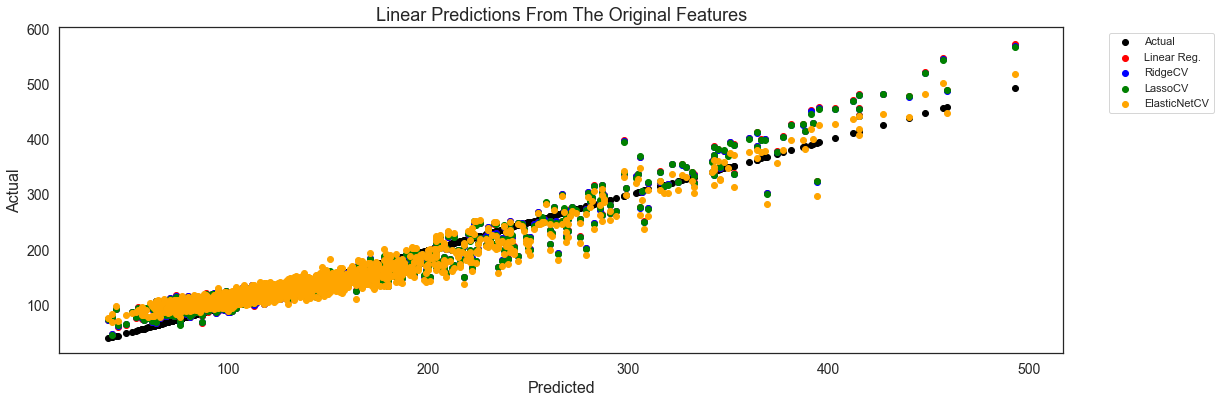

In [92]:
plot_linear_predictions(df    = original_features, 
                        true  = "Actual", 
                        title = "Original Features")

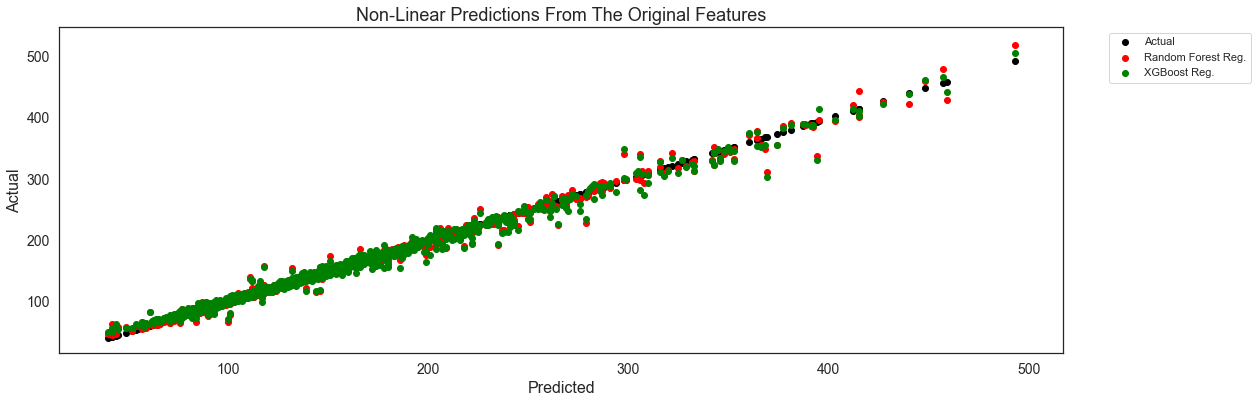

In [93]:
plot_nonlinear_predictions(df    = original_features, 
                           true  = "Actual", 
                           title = "Original Features")

The four linear models performed the best on values <200 given that the points there are overlapping so much.  However for values >200, the predictions follow the actual values but they became much more varied.

On the other hand, the non-linear models followed the true line much more closely.  Although the variance increased as the values increased, it is not as dramatic as with the linear models

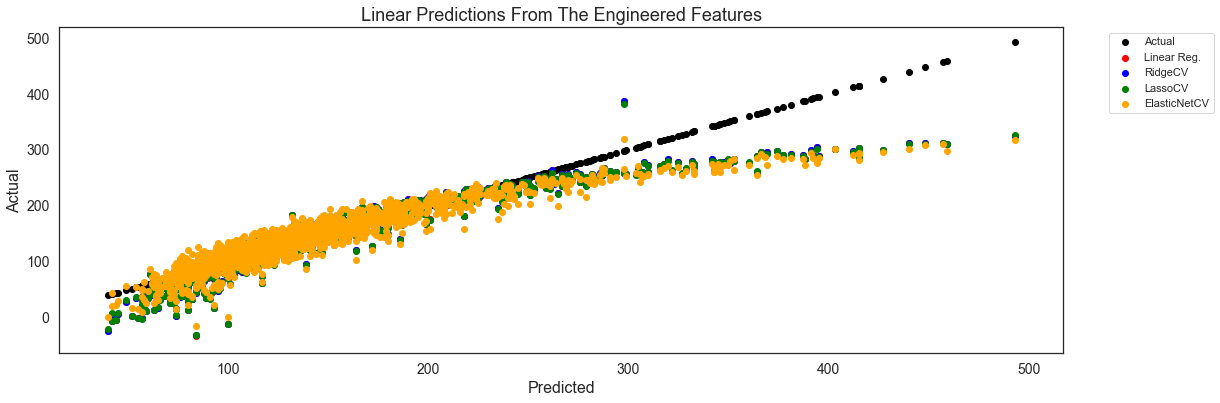

In [94]:
plot_linear_predictions(df    = engineered_features, 
                        true  = "Actual", 
                        title = "Engineered Features")

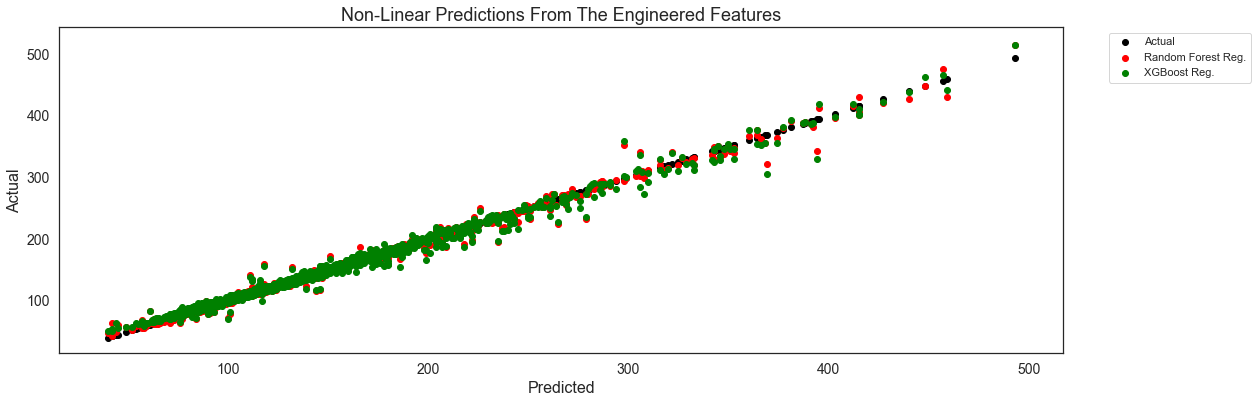

In [95]:
plot_nonlinear_predictions(df    = engineered_features, 
                           true  = "Actual", 
                           title = "Engineered Features")

The linear models (Linear to ElasticNet) have a very distinct curve where the models' accuracy begins to flatten and become much less accurate.  This is because of how heterscedastic the models are.  

On the other hand the non-linear models (Random Forest and XGBoost) are much more accurate and follow a straight line much more closely.

[Top](#Table-Of-Contents)

### Plotting Residuals

The residuals are simply the difference between the actual values and the predicted values.  Looking at the residuals allows us to detect if the independence of errors assumption is violated.

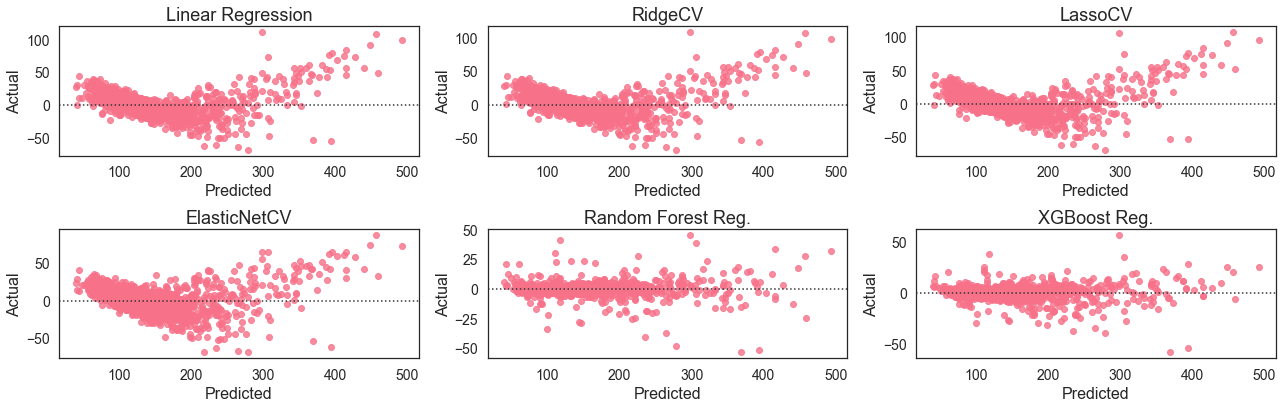

In [96]:
plot_residuals(df      = original_features,
               columns = ["Linear Reg.", "RidgeCV",
                          "LassoCV", "ElasticNetCV",
                          "Random Forest Reg.", "XGBoost Reg."],
               titles  = ["Linear Regression", "RidgeCV",
                          "LassoCV", "ElasticNetCV", "Random Forest Reg.",
                          "XGBoost Reg."])

The residual plots of the linear models are not at all surprising given the distribution of my predicted values: they are dense for low values and very disperse for high values.  That means that the data is heteroscedastic, which means that it is violating one of the assumptions of linear models: independence of errors; ideally the points would be scattered randomly along the horizontal line.

The two non-linear models are magnitudes better: the points are scattered along the line indicating that the independence of errors is not violated.

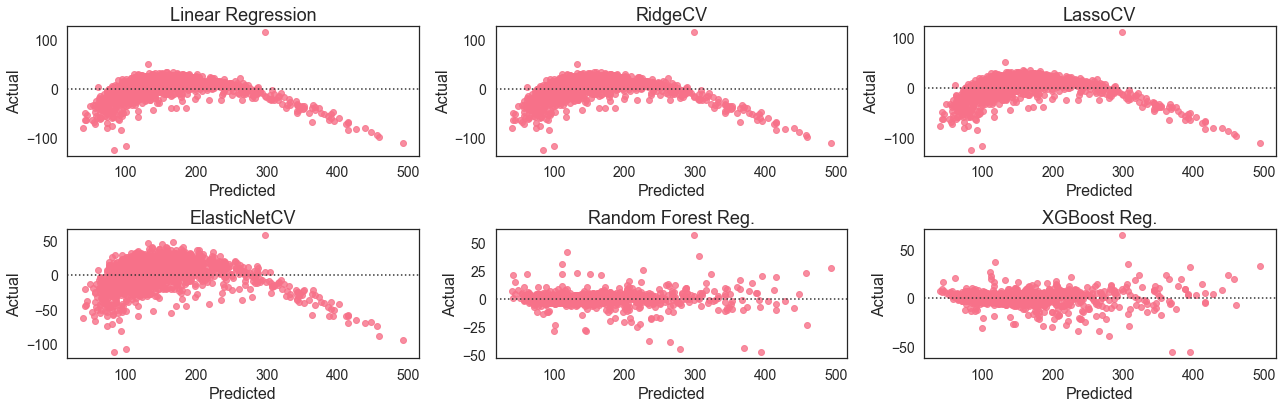

In [97]:
plot_residuals(df      = engineered_features,
               columns = ["Linear Reg.", "RidgeCV",
                          "LassoCV", "ElasticNetCV", "Random Forest Reg.",
                          "XGBoost Reg."],
               titles  = ["Linear Regression", "RidgeCV",
                          "LassoCV", "ElasticNetCV", "Random Forest Reg.",
                          "XGBoost Reg."])

These residual plots of the linear models are not at all surprising given the distribution of my predicted values: they are dense for low values and very disperse for high values.  It is easy to see where the models were underperforming for low valuess and high values. As a result, this data is also heterscedastic.

However the non-linear models are homoscedastic (the opposite of heteroscedastic).

[Top](#Table-Of-Contents)

### Final Model Choice

Model Performance With The Four Metrics With The Original Features:
    
| Metric             | Linear Regression | RidgeCV | LassoCV | ElasticNetCV | Random Forest Regression | XGBoost Regression |
|:-------------------|:-----------------:|:-------:|:-------:|:------------:|:------------------------:|:------------------:|
| RMSE               | 17.47             | 17.46   | 17.45   | 18.71        | 5.750                    | 6.801              |
| MAE                | 12.90             | 12.93   | 12.93   | 14.38        | 2.907                    | 4.012              |
| R<sup>2</sup>      | 0.9237            | 0.9238  | 0.9239  | 0.9125       | 0.9917                   | 0.9884             |
| Adj. R<sup>2</sup> | 0.9231            | -----   | -----   | -----        | 0.9916                   | 0.9883             |


Model Performance With The Four Metrics With The Engineered Features:

| Metric             | Linear Regression | RidgeCV | LassoCV | ElasticNetCV | Random Forest Regression | XGBoost Regression |
|:-------------------|:-----------------:|:-------:|:-------:|:------------:|:------------------------:|:------------------:|
| RMSE               | 23.30             | 23.11   | 23.16   | 24.88        | 5.429                    | 6.787              |
| MAE                | 14.59             | 15.23   | 15.29   | 16.69        | 2.770                    | 3.961              |    
| R<sup>2</sup>      | 0.8666            | 0.86    | 0.8659  | 0.8454       | 0.9926                   | 0.9884             |
| Adj. R<sup>2</sup> | 0.8662            | -----   | -----   | -----        | 0.9926                   | 0.9884             |


Once we had run the non-linear models, it was readily apparent to us that they were far superior to the linear models.  To that end, we chose two models as our final models:

- XGBoost Regression with the engineered features for interpretability.

- Random Forest Regression with the engineered features for accuracy.

We chose to have two final models because we wanted to produce a model that is as accurate as possible while also having a model that would be easy for us to talk about.

[Top](#Table-Of-Contents)